done
175 175 33


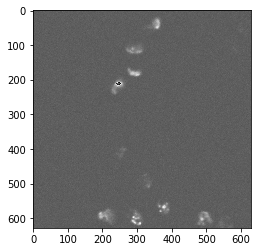

In [18]:
from __future__ import absolute_import

import cv2
import numpy as np
import os
import os.path as osp
import pdb
from matplotlib import pyplot as plt

def unit16b2uint8(img):
    if img.dtype == 'uint8':
        return img
    elif img.dtype == 'uint16':
        return img.astype(np.uint8)
    else:
        #raise TypeError('No such of img transfer type: {} for img'.format(img.dtype))
        return img.astype(np.uint8)

def img_standardization(img):
    img = unit16b2uint8(img)
    if len(img.shape) == 2:
        img = np.expand_dims(img, 2)
        img = np.tile(img, (1, 1, 3))
        return img
    elif len(img.shape) == 3:
        return img
    else:
        raise TypeError('The Depth of image large than 3 \n')
    
def load_images(file_names):
    images = []
    try:
        for file_name in file_names:
            #pdb.set_trace()
            img = cv2.imread(file_name, -1)
            img = img_standardization(img)
            images.append(img)
    except MemoryError: 
        print(file_name)
        pdb.set_trace()
    return images

def new_load_images(file_names):
    images = []
    try:
        for file_name in file_names:
            img = cv2.imread(file_name, -1)
            img = img_standardization(img)
            img = bgr_to_gray(img)
            img = img.astype('float32')
            images.append(img / 255)
    except MemoryError: 
        print(file_name)
        pdb.set_trace()
    return images

def bgr_to_gray(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img 


class BinaryThresholding:
    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, img):
        gray = bgr_to_gray(img)
        (_, binary_mask) = cv2.threshold(gray, self.threshold, 255, cv2.THRESH_BINARY)
        binary_mask = cv2.medianBlur(binary_mask, 5)
        connectivity = 4
        _, label_img, _, _ = cv2.connectedComponentsWithStats(binary_mask , connectivity , cv2.CV_32S)
        return label_img
    

def origin_main():
    segmentor = BinaryThresholding(threshold=110)
    x_train_path = './dataset1/train/'
    y_train_path = './dataset1/train_GT/SEG/'
    test_path = './dataset1/test/'
    result_path = './dataset1/test_RESRES'
    if not osp.exists(result_path):
        os.mkdir(result_path)
    x_train_list = sorted([osp.join(x_train_path, x) for x in os.listdir(x_train_path) if x.find('.tif') != -1])
    y_train_list = sorted([osp.join(y_train_path, y) for y in os.listdir(y_train_path) if y.find('.tif') != -1])
    test_list = sorted([osp.join(test_path, test) for test in os.listdir(test_path) if test.find('.tif') != -1])
    X_train = load_images(x_train_list)
    Y_train = load_images(y_train_list)
    images = load_images(test_list)
    for index, image in enumerate(images):
        label_img = segmentor(image)
        cv2.imwrite(osp.join(result_path, 'mask{:0>3d}.tif'.format(index)), label_img.astype(np.uint16))
        
    print("done")
    print(len(X_train), len(Y_train), len(images))
    plt.imshow(images[0])
    plt.show
    return

    
origin_main()

In [19]:
import numpy as np 
import os
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend

In [20]:
def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = keras.Input(shape = input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'mse', metrics = ['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])
    
    model.summary()


    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [21]:
from __future__ import print_function
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob

In [22]:
model = unet()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 256, 256, 64) 640         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_48[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_49[0][0]                  
____________________________________________________________________________________________

In [23]:
from __future__ import print_function
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob

def adjustData(img,mask,flag_multi_class,num_class):
    if(flag_multi_class):
        img = img / 255
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (num_class,))
 
        for i in range(num_class):
            new_mask[mask == i,i] = 1 #将平面的mask的每类，都单独变成一层，
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img) > 1):
        img = unit16b2uint8(img)
        mask = unit16b2uint8(mask)
        img = img / 255
        mask = mask / 255
        mask[mask > 0] = 1
        mask[mask <= 0] = 0
    return (img,mask)

def train_Generator(batch_size,train_path, mask_path, image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False, num_class = 2,save_to_dir = None,save_path = None, target_size = (256, 256),seed = 1):
    
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        mask_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        yield (img,mask)
   
        
def testGenerator(test_path,target_size = (256,256),flag_multi_class = False,as_gray = True):
    files = os.listdir(test_path)
    for file in files:
        img = cv2.imread(os.path.join(test_path,file),-1)
        img = unit16b2uint8(img)
        img = img / 255
        img = cv2.resize(img,target_size)
        img = np.reshape(img,img.shape + (1,)) if (not flag_multi_class) else img
        img = np.reshape(img,(1,) + img.shape)
        yield img


In [24]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    vertical_flip = True,
                    fill_mode='nearest')
myGene = train_Generator(2,'./dataset1','./dataset1/train_GT','train','SEG',data_gen_args)
model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(myGene,steps_per_epoch=300,epochs=2,callbacks=[model_checkpoint])

Found 175 images belonging to 1 classes.
Found 175 images belonging to 1 classes.
  ...
    to  
  ['...']
Train for 300 steps
Epoch 1/2
  1/300 [..............................] - ETA: 6:16WARNING:tensorflow:Can save best model only with loss available, skipping.


UnknownError: 2 root error(s) found.
  (0) Unknown:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model_2/conv2d_48/Conv2D (defined at <ipython-input-24-ebcb66647895>:11) ]]
	 [[metrics/mean_io_u_2/confusion_matrix/ones_like/_94]]
  (1) Unknown:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model_2/conv2d_48/Conv2D (defined at <ipython-input-24-ebcb66647895>:11) ]]
0 successful operations.
0 derived errors ignored. [Op:__inference_distributed_function_10537]

Function call stack:
distributed_function -> distributed_function


In [1]:
testGene = testGenerator(r"./dataset1/test")
results = model.predict_generator(testGene,verbose=1)
result = results[0]
print(result.shape)
result = cv2.resize(result, (256,256))
plt.imshow(result)
plt.show

NameError: name 'testGenerator' is not defined

(2, 256, 256, 1)
(2, 256, 256, 1)


<function matplotlib.pyplot.show(*args, **kw)>

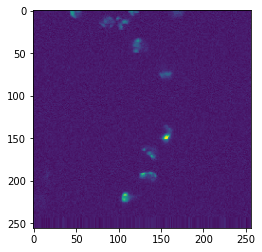

In [54]:
(img, mask) = next(myGene)
print(img.shape)
print(mask.shape)
img = cv2.resize(img[0], (256,256))
plt.imshow(img)
plt.show


<function matplotlib.pyplot.show(*args, **kw)>

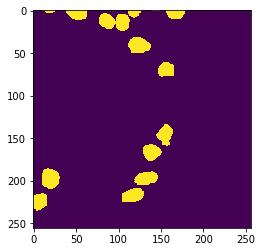

In [55]:
mask = cv2.resize(mask[0], (256,256))
plt.imshow(mask)
plt.show



<function matplotlib.pyplot.show(*args, **kw)>

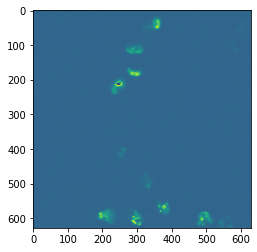

In [64]:
test = testGenerator(r"./dataset1/test")
t = next(test)
t = cv2.resize(t[0], (628,628))
plt.imshow(t)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

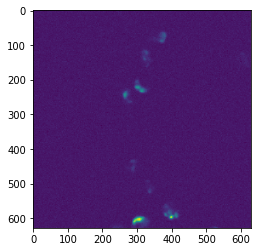

In [65]:
t = next(test)
t = cv2.resize(t[0], (628,628))
plt.imshow(t)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

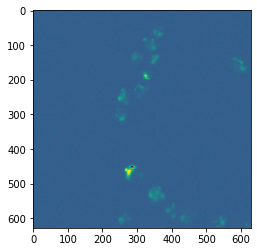

In [66]:
t = next(test)
t = cv2.resize(t[0], (628,628))
plt.imshow(t)
plt.show

In [ ]:
t = next(test)
t = cv2.resize(t[0], (628,628))
plt.imshow(t)
plt.show